# Data Analysis
Before we proceed to building our model we have to explore and prepare the data.

Notebook overview:
- data loading
- visualization
- adding indicators
- exporting to .csv files
- normalization methods

In [3]:
import pandas as pd
import numpy as np
from utils import *

# Data Loading
## NASDAQ

In [4]:
data_dir = '../data/'
nasdaq = pd.read_csv(data_dir + 'NASDAQ/Composite-2015-2019-D1.csv')

In [5]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,4726.810059,1435150000
1,2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,4652.569824,1794470000
2,2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,4592.740234,2167320000
3,2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,4650.470215,1957950000
4,2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,4736.189941,2105450000


## Adj Close
According to Yahoo! Finance specification:
- *Close* -- Close price adjusted for splits.
- *Adj Close* -- Adjusted close price adjusted for both dividends and splits.

We can see that these two columns have exact same values. Let's check whether it is true for the whole dataset and drop if it is.

In [6]:
close = np.array(nasdaq['Adj Close'])
adj_close = np.array(nasdaq['Close'])

In [7]:
len(nasdaq) - (close == adj_close).sum()

0

In [8]:
nasdaq.drop(['Adj Close'], axis=1, inplace=True)

In [9]:
nasdaq = nasdaq.set_index('Date')

In [10]:
nasdaq.index = pd.to_datetime(nasdaq.index)

We can scale Volume column down:

In [11]:
nasdaq.loc[:, 'Volume'] = nasdaq.loc[:,'Volume'] / 1e9

In [12]:
nasdaq.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,1.43515
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,1.79447
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,2.16732
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1.95795
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,2.10545


## EURUSD

In [13]:
eurusd = load_file_split(data_dir + 'EURUSD/')

In [14]:
eurusd.tail()

,Date,Time,Open,High,Low,Close,Ticks
1458710,2019.11.29,16:54,1.10176,1.10202,1.10174,1.10200,0
1458711,2019.11.29,16:55,1.10199,1.10218,1.10149,1.10149,0
1458712,2019.11.29,16:56,1.10173,1.10174,1.10173,1.10173,0
1458713,2019.11.29,16:57,1.10173,1.10174,1.10173,1.10173,0
1458714,2019.11.29,16:58,1.10157,1.10174,1.10157,1.10158,0


Do we need Ticks column?

In [15]:
eurusd[eurusd['Ticks'] != 0]

,Date,Time,Open,High,Low,Close,Ticks


In [16]:
eurusd.drop(['Ticks'], axis=1, inplace=True)

### Change timeframe
Because current size of the EURUSD dataset is large, it is best to change the timeframe to a longer one: 1H (one candle per hour).

> This operation may take some time

In [17]:
eurusd = change_timeframe(eurusd)

In [18]:
len(eurusd), len(nasdaq)

(24312, 1259)

In [19]:
eurusd.loc[:,'Date'] = eurusd.loc[:,'Date'] + ' ' + eurusd.loc[:,'Time']
eurusd.drop(['Time'], inplace=True, axis=1)
eurusd = eurusd.set_index('Date')

In [20]:
eurusd.index = pd.to_datetime(eurusd.index)

In [21]:
eurusd.head()

,Open,High,Low,Close
Date,,,,
2016-01-03 18:02:00,1.08701,1.08723,1.08633,1.08639
2016-01-03 19:02:00,1.08639,1.08650,1.08451,1.08557
2016-01-03 20:02:00,1.08544,1.08577,1.08432,1.08443
2016-01-03 21:02:00,1.08462,1.08688,1.08272,1.08644
2016-01-03 22:02:00,1.08661,1.08756,1.08583,1.08715


# Visualization & exploration
To easily plot financial history data `mplfinance` module will be needed.

In [22]:
!pip install mplfinance

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
%matplotlib inline

## Volume
For NASDAQ we have access to Volume, which indicates the number of changed shares. This can be used as additional information holder.

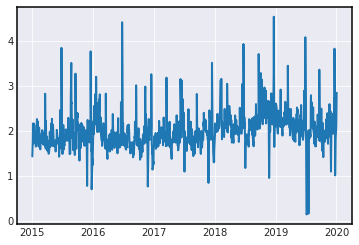

In [24]:
plt.plot(nasdaq.loc[:,'Volume'])

# Full market data
What we can see is that there can be large gaps in our time frame (especially in the EURUSD data). This happens because market is closed on weekends and holidays.

I will ignore this fact in this work, but it is important to grab some attention here. For example, adding a `Gap` column could improve accuracy.

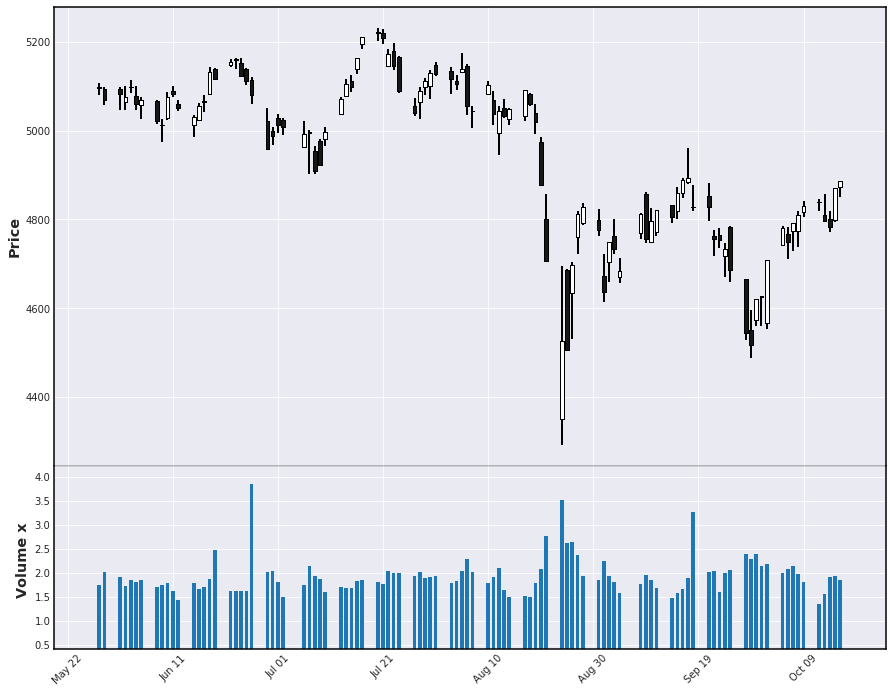

In [25]:
mpf.plot(nasdaq.iloc[100:200], type='candle', volume=True, no_xgaps=False, figscale=1.5)

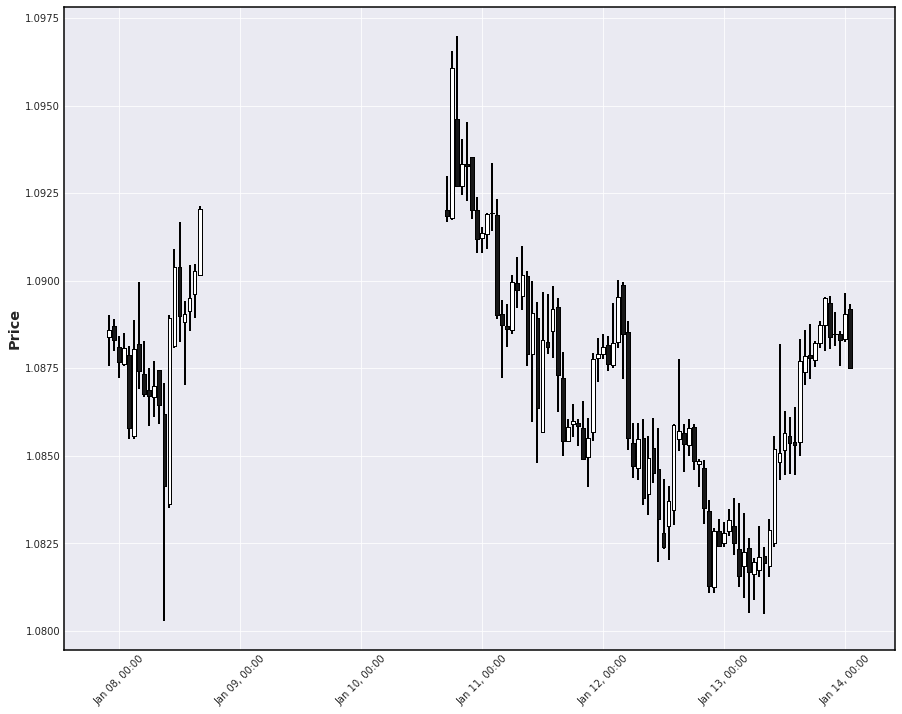

In [26]:
mpf.plot(eurusd.iloc[100:200], type='candle', no_xgaps=False, figscale=1.5)

## Values distribution
Normal distribution is a favourite of ML models. What we can see is that Volume is already well distributed. EURUSD looks quite decent, but it still has abnormally infrequent values. NASDAQ on the other hand definetely needs some transformation, since it is nowhere close to normal distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc1a9f390>,
      dtype=object)

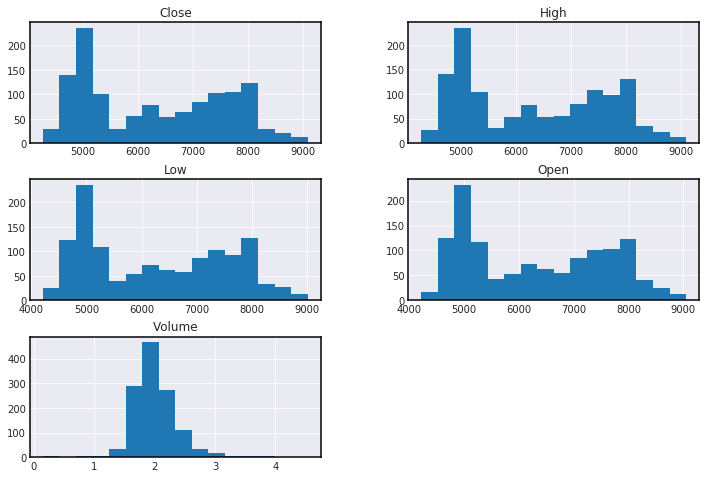

In [27]:
nasdaq.hist(figsize=(12,8), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc193c438>,
      dtype=object)

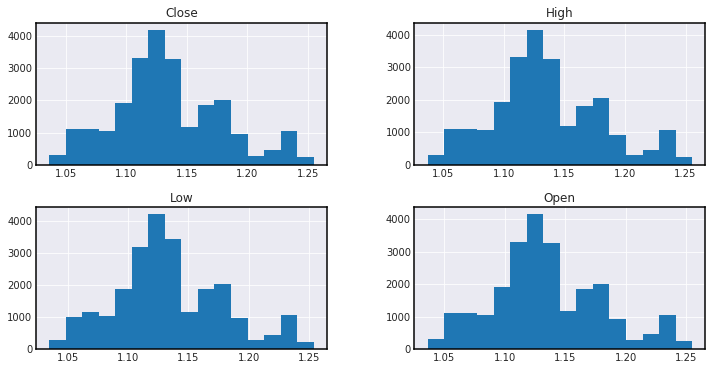

In [28]:
eurusd.hist(figsize=(12,6), bins=16)

# Indicators
Using this data, we can calculate any indicator we want.
I have chosen a few popular indicators and implemented them in the `indicators` module, which you can find in this project.

> **Warning:** applying indicators can take a long time! They are iterating over the dataset which is very large.

In [29]:
import indicators
# SMA(N=5)
# EMA(P=0.5)
# Momentum()
# RSI(period=14)

In [30]:
nasdaq = indicators.EMA(nasdaq, P=0.04)
nasdaq = indicators.SMA(nasdaq, N=50)
nasdaq = indicators.Momentum(nasdaq)
nasdaq = indicators.RSI(nasdaq, period=14)

In [31]:
nasdaq.head(10)

,Open,High,Low,Close,Volume,EMA,SMA,Momentum,RSI
Date,,,,,,,,,
2015-01-02,4760.240234,4777.009766,4698.109863,4726.810059,1.43515,4726.810059,4726.810059,0.000000,0.000000
2015-01-05,4700.339844,4702.770020,4641.459961,4652.569824,1.79447,4723.840450,4726.810059,-74.240235,0.000000
2015-01-06,4666.850098,4667.330078,4567.589844,4592.740234,2.16732,4718.596441,4689.689942,-59.829590,0.000000
2015-01-07,4626.839844,4652.720215,4613.899902,4650.470215,1.95795,4715.871392,4657.373372,57.729981,0.000000
2015-01-08,4689.540039,4741.379883,4688.020020,4736.189941,2.10545,4716.684134,4655.647583,85.719726,33.333333
2015-01-09,4744.470215,4744.709961,4681.240234,4704.069824,1.71583,4716.179562,4671.756055,-32.120117,50.000000
2015-01-12,4714.069824,4715.810059,4650.649902,4664.709961,1.86196,4714.120777,4677.141683,-39.359863,40.000000
2015-01-13,4708.740234,4751.339844,4624.279785,4661.500000,2.16218,4712.015946,4675.365723,-3.209961,33.333333
2015-01-14,4610.759766,4655.370117,4595.979980,4639.319824,2.07381,4709.108101,4673.632507,-22.180176,28.571429


In [32]:
eurusd = indicators.EMA(eurusd, P=0.02)
eurusd = indicators.SMA(eurusd, N=100)
eurusd = indicators.Momentum(eurusd)
eurusd = indicators.RSI(eurusd, period=14)

In [33]:
eurusd.head(10)

,Open,High,Low,Close,EMA,SMA,Momentum,RSI
Date,,,,,,,,
2016-01-03 18:02:00,1.08701,1.08723,1.08633,1.08639,1.086390,1.086390,0.00000,0.000000
2016-01-03 19:02:00,1.08639,1.08650,1.08451,1.08557,1.086374,1.086390,-0.00082,0.000000
2016-01-03 20:02:00,1.08544,1.08577,1.08432,1.08443,1.086335,1.085980,-0.00114,0.000000
2016-01-03 21:02:00,1.08462,1.08688,1.08272,1.08644,1.086337,1.085463,0.00201,0.000000
2016-01-03 22:02:00,1.08661,1.08756,1.08583,1.08715,1.086353,1.085708,0.00071,33.333333
2016-01-03 23:02:00,1.08726,1.08728,1.08669,1.08711,1.086368,1.085996,-0.00004,50.000000
2016-01-04 00:02:00,1.08716,1.08834,1.08693,1.08822,1.086405,1.086182,0.00111,40.000000
2016-01-04 01:02:00,1.08764,1.09048,1.08740,1.08925,1.086462,1.086473,0.00103,50.000000
2016-01-04 02:02:00,1.08957,1.09024,1.08844,1.08918,1.086517,1.086820,-0.00007,57.142857


## Correlations

It is obvious that price values are strongly correlated. What we want to look at is correlation with `Volume` and indicators.

Weaker correlation is better, because it means that our data potentially carries more useful information instead of repeating itself.

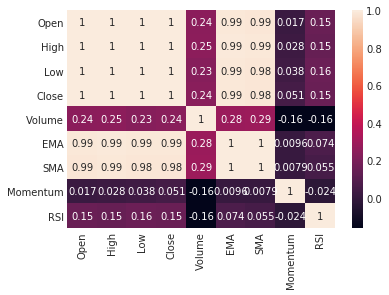

In [34]:
sns.heatmap(nasdaq.corr(), annot=True)

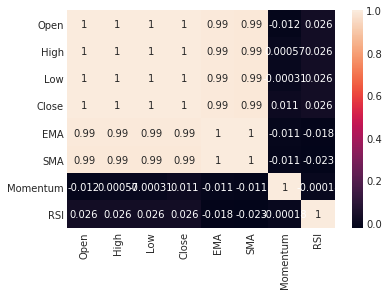

In [35]:
sns.heatmap(eurusd.corr(), annot=True)

# Simplified forecast
We can make prediction problem easier -- predict the close price only.

In [36]:
def plot_all(data):
    plt.figure(figsize=(12,16))
    plt.subplot(311)
    plt.plot(data.iloc[:, data.columns.get_loc('Close')])
    plt.plot(data.iloc[:, data.columns.get_loc('EMA')], 'r')
    plt.plot(data.iloc[:, data.columns.get_loc('SMA')], 'g')
    plt.subplot(312)
    plt.plot(data.iloc[:, data.columns.get_loc('Momentum')])
    plt.subplot(313)
    plt.plot(data.iloc[:, data.columns.get_loc('RSI')])

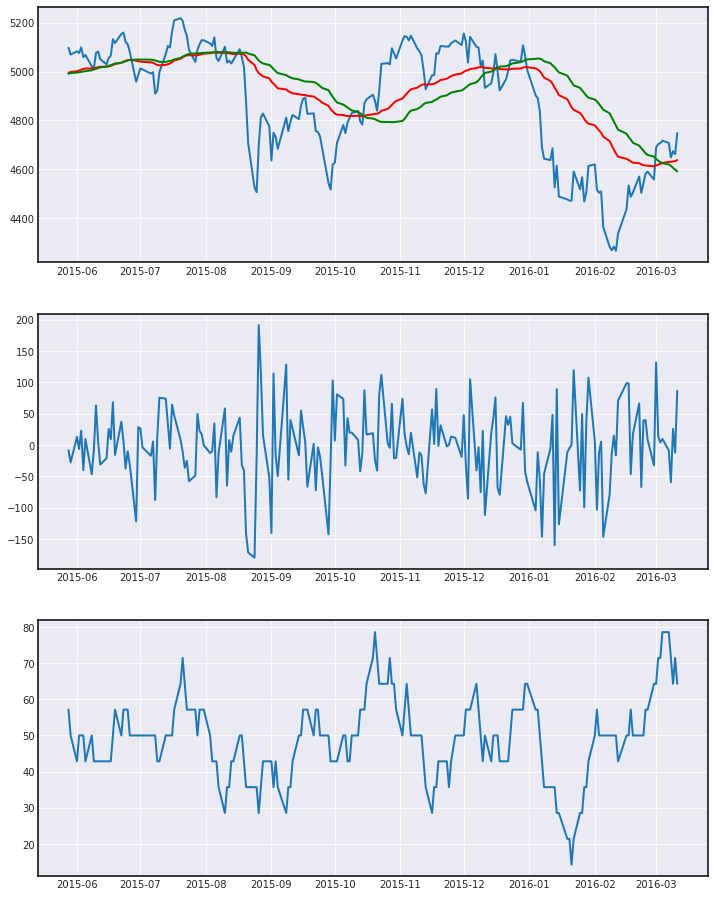

In [37]:
plot_all(nasdaq.iloc[100:300])

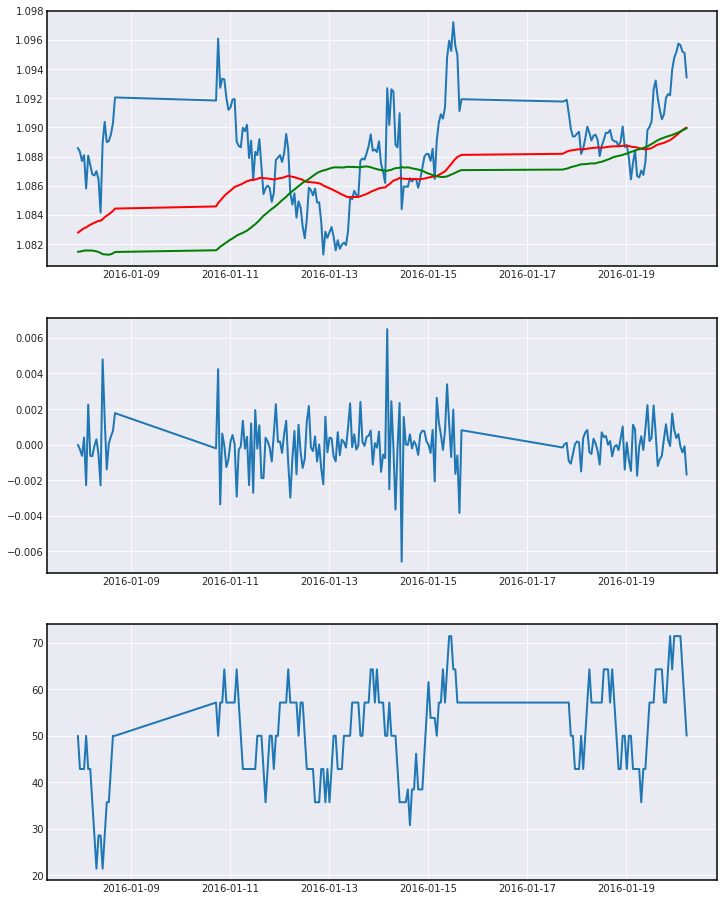

In [38]:
plot_all(eurusd.iloc[100:300])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc04f40f0>,
      dtype=object)

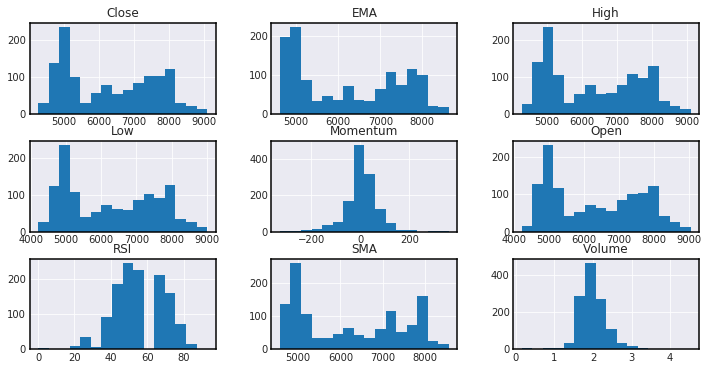

In [39]:
nasdaq.hist(figsize=(12,6), bins=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc0265208>,
      dtype=object)

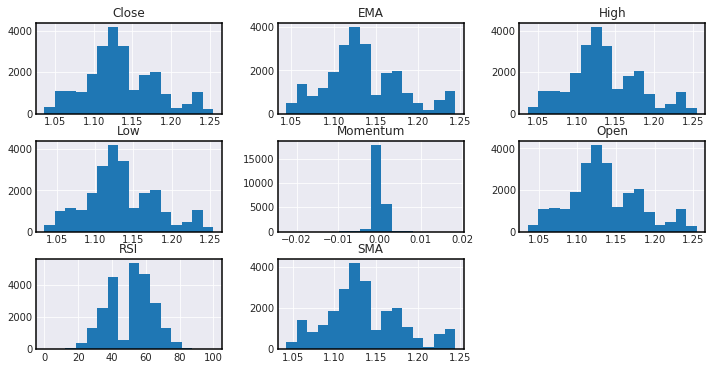

In [40]:
eurusd.hist(figsize=(12,6), bins=16)

# Export to CSV
Save our datasets to `train.csv` and `test.csv` files. I will cut first 10 rows because they have less accurate indicators' values, which was caused by missing data from the past.

Of course data is not shuffled, we want it in chronological order.

In [41]:
len(nasdaq), len(eurusd)

(1259, 24312)

In [42]:
0.8 * np.array([len(nasdaq), len(eurusd)])

array([ 1007.2, 19449.6])

In [43]:
import os.path

In [45]:
nasdaq.iloc[10:1000].to_csv(os.path.join(data_dir, 'nasdaq_export', 'train.csv'), header=False)
nasdaq.iloc[1000:].to_csv(os.path.join(data_dir, 'nasdaq_export', 'test.csv'), header=False)

In [46]:
eurusd.iloc[10:19450].to_csv(os.path.join(data_dir, 'eurusd_export', 'train.csv'), header=False)
eurusd.iloc[19450:].to_csv(os.path.join(data_dir, 'eurusd_export', 'test.csv'), header=False)

# Normalization
Market value can go as low as 0 and up to infinity, because we want our model to predict values in any range we need to work in a normalized space.
What is more, values distribution is very uneven, these transformations may help solve this problem.

I will showcase a few different normalization approaches:

Trainable:
- Convolution
- Batch normalization

Hyperparametrized:
- Moving Average

For this example transformation is being applied to every column. This is not always necessary, in fact some indicators are already normalized.
Such indicators are called osciallators (typically they range from 0 to 100), *RSI* is an oscillator.

## 1. Convolution example
This is an example of how a trained filter may look like:

> **Note:** The first 2 entries should be removed! They are not transformed an should not be plotted.

In [54]:
def conv(cf, data):
    filtered = data.copy()
    for col in range(0, len(data.columns)):
        for i in range(2, len(data)):
            filtered.iloc[i, col] = np.array(data.iloc[i-2:i+1, col]) @ cf
    return filtered

In [55]:
conv_filter = np.array([0.2, -1, 0.8])
conv_eurusd = conv(conv_filter, eurusd.iloc[100:800].copy())

# get rid of incorrect entries (we have not applied padding - data is lost)
conv_eurusd = conv_eurusd.iloc[2:]

conv_eurusd.head()

,Open,High,Low,Close,EMA,SMA,Momentum,RSI
Date,,,,,,,,
2016-01-08 00:03:00,-0.000532,-0.000376,-0.000698,-0.000450,0.000055,0.000018,-0.000236,1.428571
2016-01-08 01:03:00,-0.000274,0.000172,0.000434,0.000446,0.000062,0.000021,0.000896,0.000000
2016-01-08 02:03:00,0.000314,-0.000314,-0.001750,-0.001904,0.000023,0.000007,-0.002350,5.714286
2016-01-08 03:03:00,-0.001918,0.000666,0.000428,0.002256,0.000068,-0.000014,0.004160,-7.142857
2016-01-08 04:03:00,0.002570,0.000724,0.001134,-0.000954,0.000047,0.000010,-0.003210,1.428571


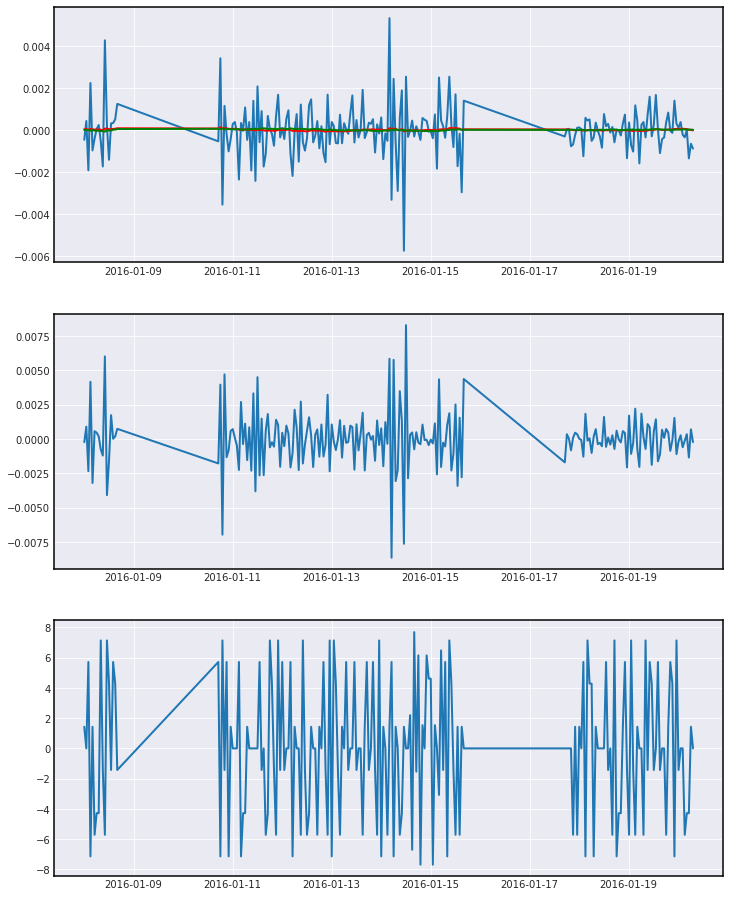

In [56]:
plot_all(conv_eurusd.iloc[:200])

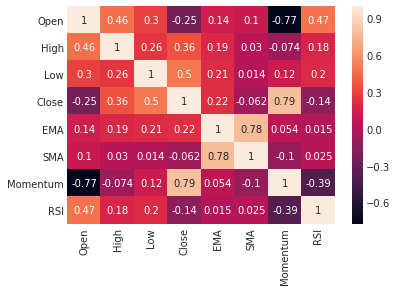

In [57]:
sns.heatmap(conv_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9149f37f60>,
      dtype=object)

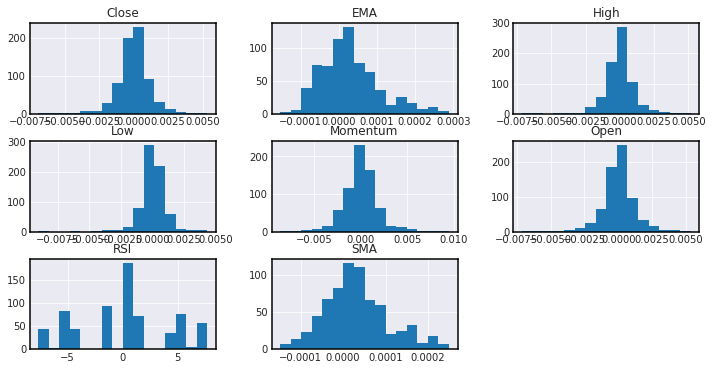

In [58]:
conv_eurusd.hist(figsize=(12,6), bins=16)

### Convolution - summary
Convolution looks very promising for this task. Histograms for the data indicate that data is well distributed, correlation matrix improved drastically -- we have much more valueable data now.

> It is worth pointing out that RSI looks a little suspicious. In fact this is because a short period parameter value of 14 (a larger value would make it look smoother).

## 2. Batch normalization
For comparison example of batch normalization without trainable parameters (set to not infuelence the data).

In [64]:
def batch_norm(data, eps=0, gamma=1, beta=0):
    import math
    std = data.std()
    mean = data.mean()
    for col in range(0, len(data.columns)):
        for i in range(0, len(data)):
            data.iloc[i, col] = (data.iloc[i, col] - mean[col]) * gamma / math.sqrt(std[col]**2 + eps) + beta
    return data

In [65]:
batch_eurusd = batch_norm(eurusd.iloc[100:300].copy())
batch_eurusd.head()

,Open,High,Low,Close,EMA,SMA,Momentum,RSI
Date,,,,,,,,
2016-01-07 22:03:00,-0.025704,-0.152836,0.021472,0.020919,-2.397153,-1.974555,-0.024105,-0.078992
2016-01-07 23:03:00,0.065877,-0.188510,0.149059,-0.061294,-2.329871,-1.965354,-0.208168,-0.787197
2016-01-08 00:03:00,-0.114231,-0.337154,-0.090555,-0.253124,-2.271582,-1.953853,-0.463024,-0.787197
2016-01-08 01:03:00,-0.263812,-0.310398,0.018360,-0.131327,-2.209603,-1.940220,0.266147,-0.787197
2016-01-08 02:03:00,-0.181390,-0.420394,-0.635132,-0.825569,-2.176544,-1.933319,-1.631113,-0.078992


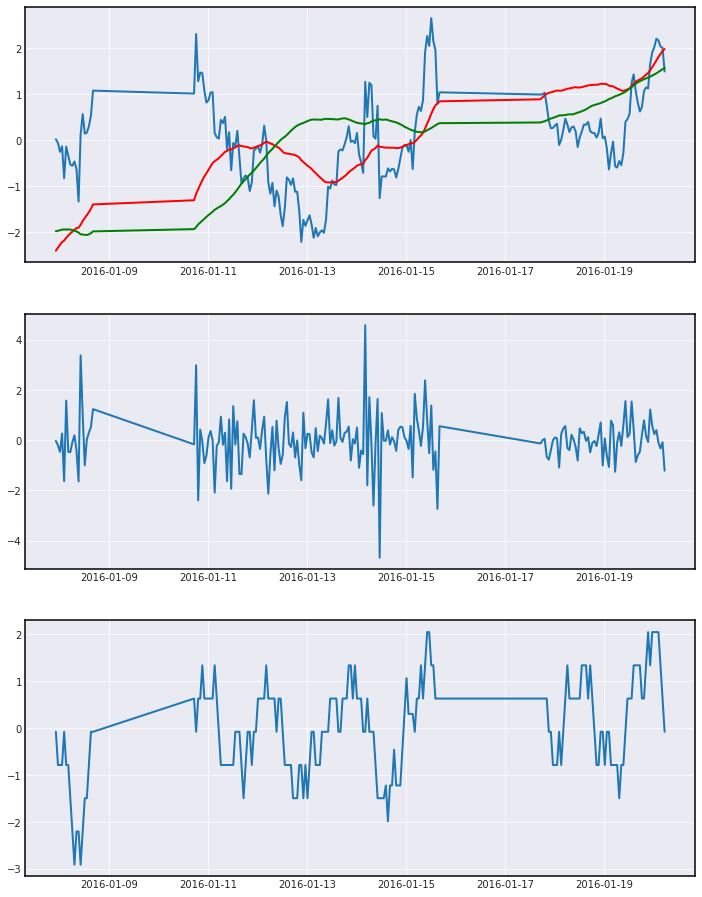

In [66]:
plot_all(batch_eurusd)

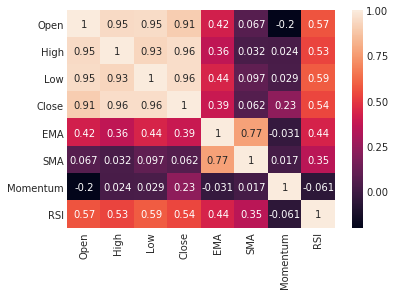

In [67]:
sns.heatmap(batch_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9149690978>,
      dtype=object)

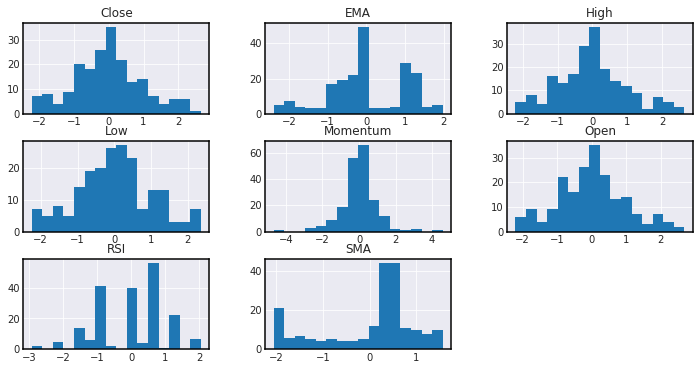

In [68]:
batch_eurusd.hist(figsize=(12,6), bins=16)

### Batch norm - summary
Batch normalization is definetely less aggressive in transforming the data, but quite effective. It can be applied in our model.

> Downside of this solution is that it works well only on relatively small batches.

## 3. Moving Average
For reference I want to test a hyperparametrized approach as well. Hyperparameter is the Moving Average length parameter (N).

In [69]:
def ma_norm(data):
    for col in range(0, len(data.columns)):
        for i in range(0, len(data)):
            data.iloc[i, col] = data.iloc[i, col] - data.iloc[i, data.columns.get_loc('SMA')]
    return data

In [70]:
ma_eurusd = ma_norm(eurusd.iloc[100:800].copy())
ma_eurusd.head()

,Open,High,Low,Close,EMA,SMA,Momentum,RSI
Date,,,,,,,,
2016-01-07 22:03:00,0.006933,0.007563,0.006113,0.007123,0.001311,0.0,-0.00001,50.000000
2016-01-07 23:03:00,0.007211,0.007421,0.006501,0.006831,0.001400,0.0,-0.00027,42.857143
2016-01-08 00:03:00,0.006594,0.006894,0.005704,0.006174,0.001469,0.0,-0.00063,42.857143
2016-01-08 01:03:00,0.006071,0.006951,0.006021,0.006541,0.001538,0.0,0.00040,42.857143
2016-01-08 02:03:00,0.006325,0.006565,0.003905,0.004245,0.001576,0.0,-0.00228,50.000000


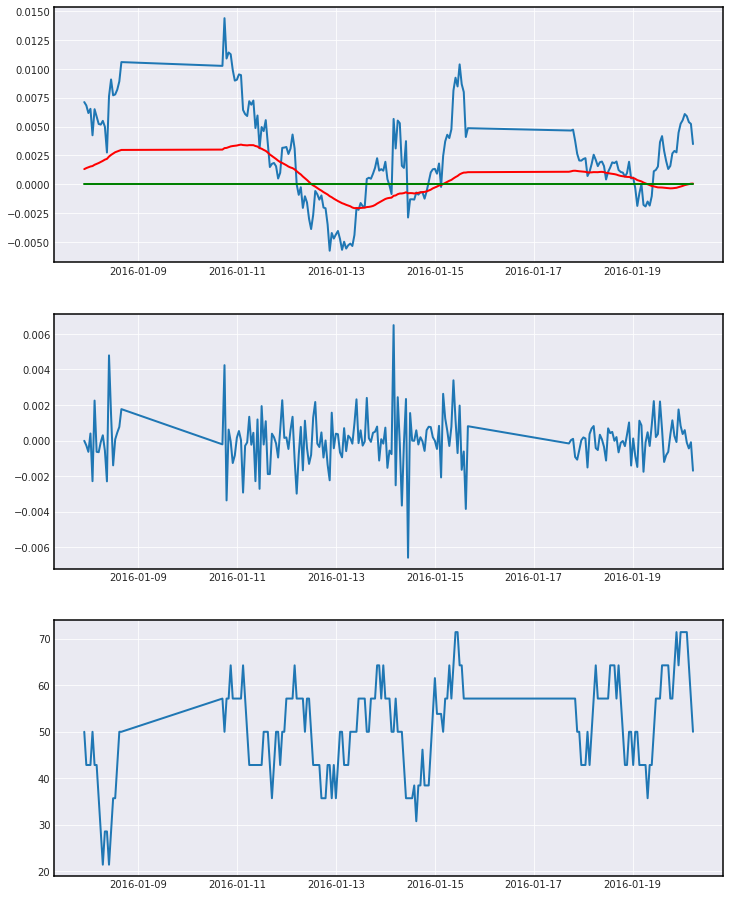

In [71]:
plot_all(ma_eurusd.iloc[:200])

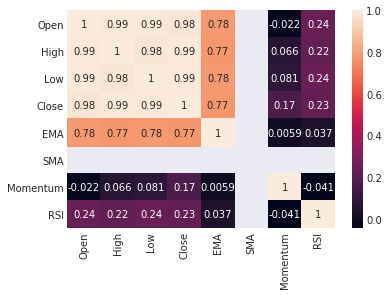

In [72]:
sns.heatmap(ma_eurusd.corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9149099518>,
      dtype=object)

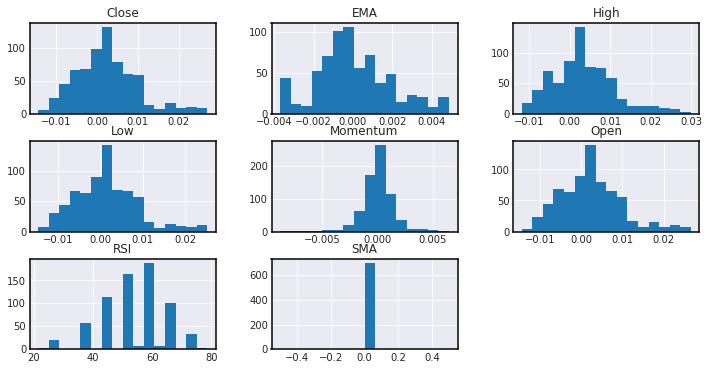

In [73]:
ma_eurusd.hist(figsize=(12,6), bins=16)

### MA - summary
This method still gives us pretty good results. In relation to its simplicity this could work very well, but I will not use it in the final model because of 3 reasons:
- discards SMA indicator (which can be fixed if we add another with different N parameter),
- harder to implement than batch normalization,
- it is not trainable like 2 other methods above but hyperparametrized instead.

# Summary
We have loaded, explored, tested and exported our data for training. Now it is time to build a model, which will be explained and performed in the `Model.ipynb` notebook.